# Install Dependencies and Setup

In [2]:
# what version of Python do you have?
import sys
import os

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

# check whether the GPU is available
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Python Platform: macOS-13.1-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is available


In [3]:
# additional ibraries for tensorflow image cassification tasks
import pathlib # object-oriented filesystem paths
import matplotlib.pyplot as plt
import numpy as np
import PIL # python imaging library for image processing capabilities

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



# Explore the Datasets

## Image Dataset

In [44]:
# get current working directory
current_dir = os.getcwd()
current_dir

'/Users/marcdeheeger/PythonProjects/MSDS 498/Mushroom Project/Master'

In [18]:
# create pathlib.PosixPath object for directory containing images
data_dir = 'data/images/mushroom_images' # put in path to your image directory in place here
data_dir = pathlib.Path(data_dir)

In [65]:
data_dir

PosixPath('data/images/mushroom_images')

In [66]:
os.listdir(data_dir)

['king bolete - Google Search - 2_25_2023 4-52-16 PM',
 'cantharellus cibarius - Google Search - 2_23_2023 12-04-53 PM',
 'anmanita muscaria - Google Search - 2_23_2023 11-37-51 AM']

In [73]:
# number of images in the image directory
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

444


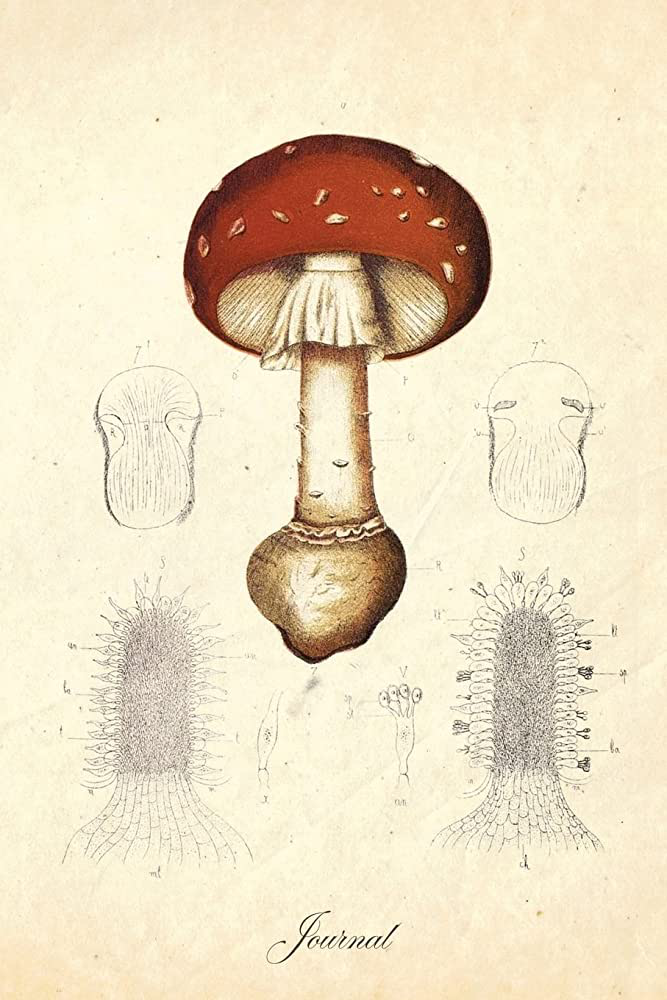

In [74]:
# example image
amanita_muscaria = list(data_dir.glob('anmanita muscaria - Google Search - 2_23_2023 11-37-51 AM/*'))
PIL.Image.open(str(amanita_muscaria[0]))

In [123]:
class_names = train_ds.class_names
print(class_names)

['anmanita muscaria - Google Search - 2_23_2023 11-37-51 AM', 'cantharellus cibarius - Google Search - 2_23_2023 12-04-53 PM', 'king bolete - Google Search - 2_25_2023 4-52-16 PM']


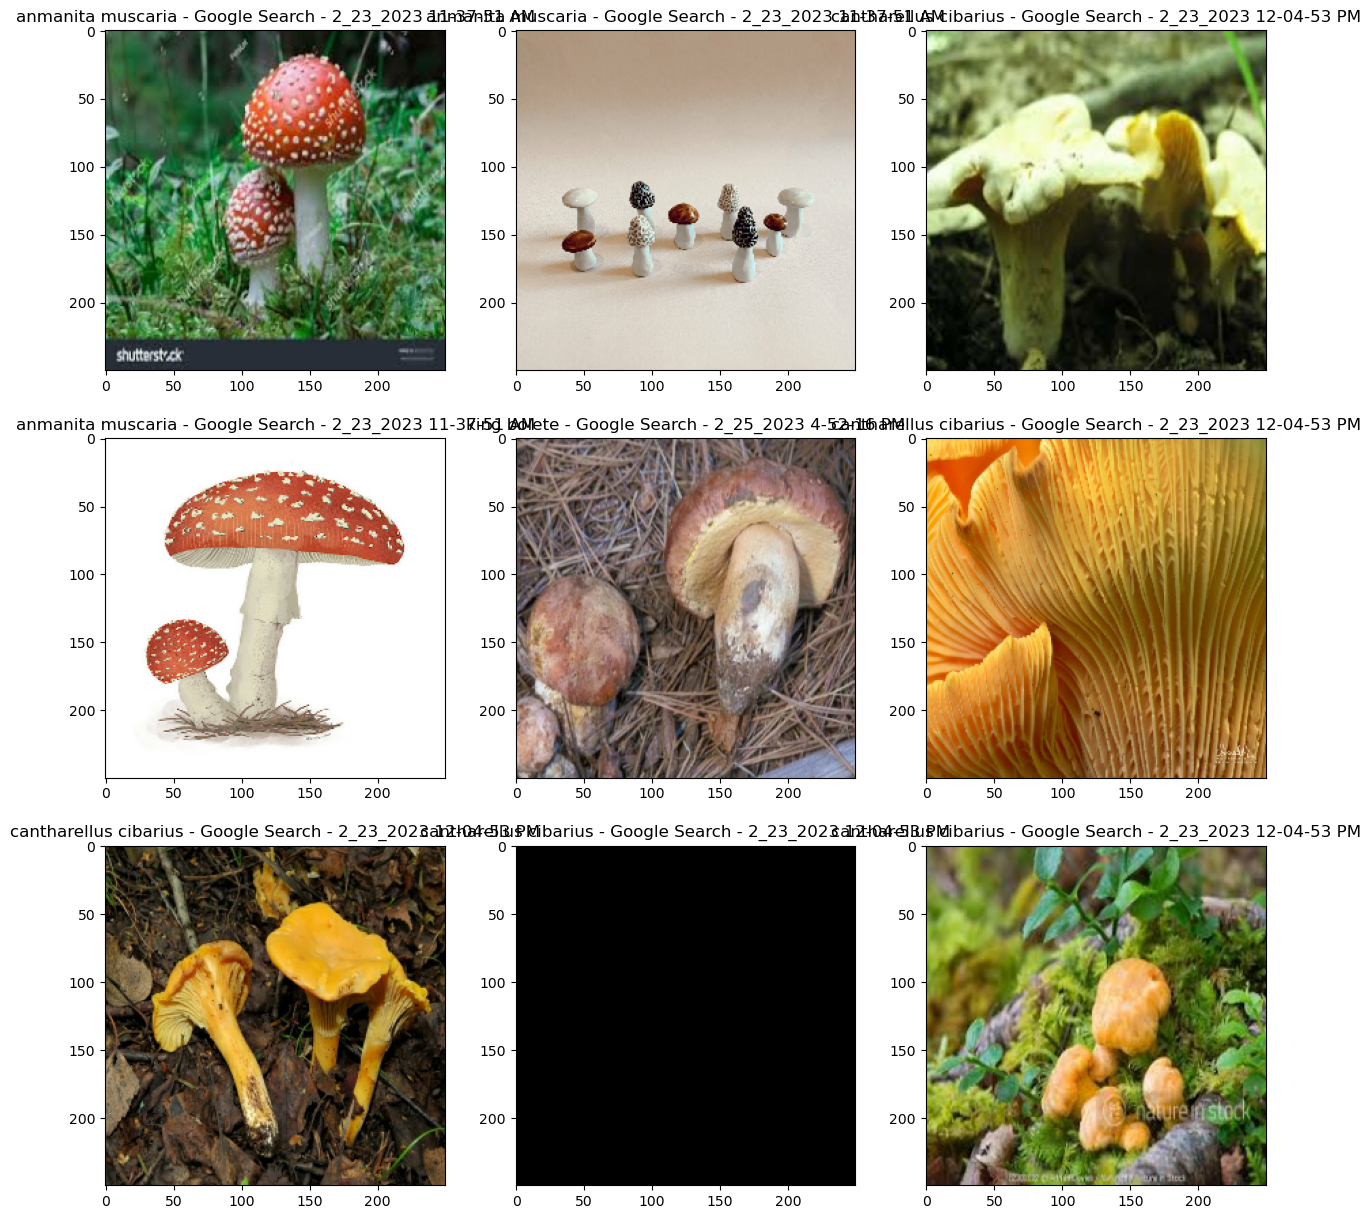

In [124]:
plt.figure(figsize = (15,15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('on')

## Tabular Data

### Initial datasets

In [217]:
# characteristics of species
df_primary = pd.read_csv('data/tabular/primary_data_edited.csv', delimiter=';', header=None)

In [219]:
df_primary.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,family,name,class,cap-diameter,cap-shape,Cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,Spore-print-color,habitat,season
1,Amanita Family,Fly Agaric,p,"[10, 20]","[x, f]","[g, h]","[e, o]",[f],[e],NaN,...,[s],[y],[w],[u],[w],[t],"[g, p]",NaN,[d],"[u, a, w]"
2,Amanita Family,Panther Cap,p,"[5, 10]","[p, x]",[g],[n],[f],[e],NaN,...,NaN,[y],[w],[u],[w],[t],[p],NaN,[d],"[u, a]"
3,Amanita Family,False Panther Cap,p,"[10, 15]","[x, f]",NaN,"[g, n]",[f],[e],NaN,...,NaN,NaN,[w],[u],[w],[t],"[e, g]",NaN,[d],"[u, a]"
4,Amanita Family,The Blusher,e,"[5, 15]","[x, f]",NaN,[n],[t],NaN,NaN,...,[b],NaN,[w],[u],[w],[t],[g],NaN,[d],"[u, a]"


In [215]:
# secondary samples generated from mushroom characteristic parameters
# filtering these out by species accordingn to meta data description that says they are ordered
df_secondary = pd.read_csv('data/tabular/secondary_data_generated.csv', delimiter=';')

In [216]:
df_secondary.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [ ]:
cap_diameter = []
cap_shape = []
cap_surface = 
cap_color = 
does_bruise_bleed = 
gill_attachment = 
gill_spacing = 
gill_color = 
stem_height = 
stem_width = 
stem_root = 
stem_surface = 
stem_color = veil_type = 
has_ring = 
ring_type = 
spore_print_color = 
habitat = 
season = 

### Selecting data for training

In [264]:
df_selected_rows = df_secondary.loc[np.r_[0:353, 48362:48715, 54362:54715, ], :]

In [265]:
df_selected_data = df_selected_rows[['class','cap-shape', 'cap-color', 'cap-diameter','stem-color']]

In [260]:
df_selected_data['species'] = 'fly agaric'

/var/folders/48/5135ttxs0wn09qqbvdw_6n7r0000gn/T/ipykernel_40681/3518940609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_data['species'] = 'fly agaric'


In [268]:
df_selected_data['species'][0:353] = 'fly agaric'
df_selected_data['species'][353:706] = 'king bolete'
df_selected_data['species'][707:1059] = 'chantarelle'

/var/folders/48/5135ttxs0wn09qqbvdw_6n7r0000gn/T/ipykernel_40681/2001913423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_data['species'][0:353] = 'fly agaric'
/var/folders/48/5135ttxs0wn09qqbvdw_6n7r0000gn/T/ipykernel_40681/2001913423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_data['species'][353:706] = 'king bolete'
/var/folders/48/5135ttxs0wn09qqbvdw_6n7r0000gn/T/ipykernel_40681/2001913423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [269]:
df_selected_data['species'].unique()

array(['fly agaric', 'king bolete', 'chantarelle'], dtype=object)

In [270]:
df_selected_columns.shape

(1059, 6)

In [271]:
df_secondary_data.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


# Prepare Datasets

## Prepare tabular dataset

## Prepare image dataset

### Image dataset generation using new image_dataset_from_directory Feature of Tensorflow 2.0

In [75]:
batch_size = 32
img_height = 250
img_width = 250

In [78]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 416 files belonging to 3 classes.
Using 333 files for training.


In [79]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 416 files belonging to 3 classes.
Using 83 files for validation.


In [109]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


# Create Models

## Single Models

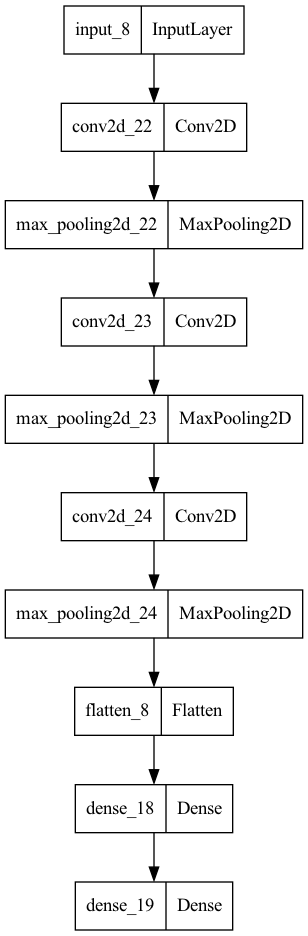

In [116]:
# images cnn model

num_classes = len(class_names)

cnn = Input(shape=(250, 250, 3))
# x = Rescaling(1./255, input_shape=(img_height, img_width, 3))
x = Conv2D(16, 3, padding='same', activation='relu')(cnn)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes)(x)

model_cnn = Model(inputs=cnn, outputs=x)
plot_model(cnn_model, to_file='convolutional_neural_network.png')


In [117]:
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [118]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 125, 125, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 62, 62, 64)       

## Dual-input Model

In [82]:
# requirements for dual-input model
from tensorflow.keras.models import Model

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# define cnn architecture for images
input_pic = layers.Input(shape=(250, 250, 3))
x         = layers.

# Train Models

In [120]:
# training single cnn model
epochs=10
history = model_cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 2s 77ms/step - loss: 0.7943 - accuracy: 0.8649 - val_loss: 0.9502 - val_accuracy: 0.7831
Epoch 2/10
11/11 [==============================] - 2s 78ms/step - loss: 0.3302 - accuracy: 0.9069 - val_loss: 3.1247 - val_accuracy: 0.6265
Epoch 3/10
11/11 [==============================] - 2s 78ms/step - loss: 0.3616 - accuracy: 0.9219 - val_loss: 1.1233 - val_accuracy: 0.6747
Epoch 4/10
11/11 [==============================] - 2s 80ms/step - loss: 0.3373 - accuracy: 0.8799 - val_loss: 1.3580 - val_accuracy: 0.6627
Epoch 5/10
11/11 [==============================] - 2s 76ms/step - loss: 0.2703 - accuracy: 0.9159 - val_loss: 1.8971 - val_accuracy: 0.6627
Epoch 6/10
11/11 [==============================] - 2s 77ms/step - loss: 0.2641 - accuracy: 0.9099 - val_loss: 0.9693 - val_accuracy: 0.7711
Epoch 7/10
11/11 [==============================] - 2s 77ms/step - loss: 0.3090 - accuracy: 0.9069 - val_loss: 1.0616 - val_accuracy: 0.7349
Epoch 8/10
11

In [115]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1

In [34]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-03-02 15:16:21.216366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 2.9797 - accuracy: 0.3153

2023-03-02 15:16:23.025306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 94ms/step - loss: 2.9797 - accuracy: 0.3153 - val_loss: 1.1240 - val_accuracy: 0.3133
Epoch 2/10
11/11 [==============================] - 2s 77ms/step - loss: 1.0753 - accuracy: 0.5135 - val_loss: 1.1556 - val_accuracy: 0.3253
Epoch 3/10
11/11 [==============================] - 2s 78ms/step - loss: 1.0128 - accuracy: 0.5345 - val_loss: 1.2147 - val_accuracy: 0.3133
Epoch 4/10
11/11 [==============================] - 2s 77ms/step - loss: 0.8908 - accuracy: 0.6126 - val_loss: 0.8589 - val_accuracy: 0.6867
Epoch 5/10
11/11 [==============================] - 2s 77ms/step - loss: 0.6034 - accuracy: 0.7568 - val_loss: 0.7485 - val_accuracy: 0.6988
Epoch 6/10
11/11 [==============================] - 2s 78ms/step - loss: 0.4234 - accuracy: 0.8378 - val_loss: 0.6037 - val_accuracy: 0.7952
Epoch 7/10
11/11 [==============================] - 2s 77ms/step - loss: 0.2792 - accuracy: 0.9069 - val_loss: 0.8471 - val_accuracy: 0.6747
Epoch 8/10
11/11 [======

## Review Model Performance

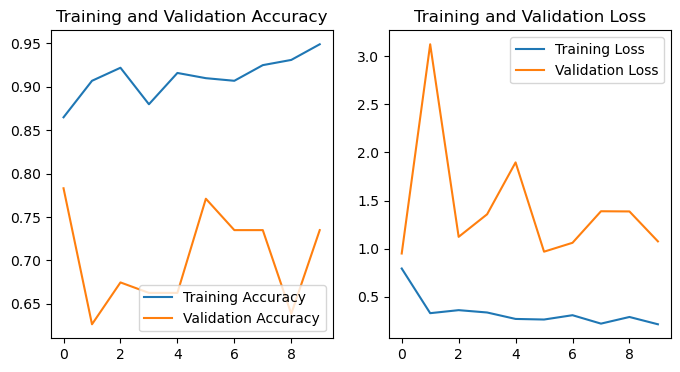

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 7. Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
pip install tensorflow-macos==2.10

In [ ]:
pip install tensorflow-metal==0.6

In [ ]:
train[0]

In [ ]:
with tf.device('/device:GPU:0'):
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
train

In [ ]:
with tf.device('/cpu:0'):
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(x_train, y_train)

In [ ]:
train

# PLAYGROUND

In [143]:
import random

In [150]:
random.seed(123)
random.random()

0.052363598850944326

In [151]:
random.randint(10,100)

21

In [152]:
random.uniform(10,100)

79.20607497283636

In [154]:
import numpy as np
stem_color = ('green', 'red', 'blue')
np.random.choice(stem_color)

'green'